## Import required packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import os
import time
from pathlib import Path
import functools as ft
import data_processing_methods as dpm
import multiprocessing as mp
from multiprocessing import  Pool

## Identify the sensors with useful data

In [2]:
# Read the csv file with sensors in use
sensors_TRUE_colnames=pd.read_csv('/raid/nmis-ddm/nmis-furnace/Sensors/sensors_TRUE.csv', header = None)
sensors_TRUE_colnames.columns = ["Sensors", "Condition"]

# Collect the sensor with True condition.
list_true = sensors_TRUE_colnames[sensors_TRUE_colnames['Condition']==True]['Sensors'].tolist()

## Align sensor data

In [ ]:
# Function for selecting required time range and interplotaing them for the required sampling frequency
def index_todatetime(df):    
    # Define the start and end date
    start_date = '2022-09-06'
    end_date = '2022-10-14'
    
    #create empty df from start date and end date with the required sampling frequency
    sampling_frequency='10S'
    expected_dt_df = pd.DataFrame({'Date' : pd.date_range(start_date, end_date, freq=sampling_frequency)})
    expected_date_time = pd.to_datetime(expected_dt_df['Date'], yearfirst=True)
    
    # Isolate required date range
    date_time = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
   
    
    data_raw = df['Value']
    data_raw, date_time = dpm.isolate_time_period(data_raw, date_time,
                                               start_date, end_date)
    
    # Convert to seconds and interpolate
    x_ts, ff_ts = dpm.convert_to_seconds(date_time, expected_date_time)
    data_raw = dpm.interpolate(data_raw, x_ts, ff_ts)
    
    # Save the new dataframes
    df_new = pd.DataFrame({})
    df_new.index = expected_date_time
    df_new['Value'] = data_raw
           
    return df_new

# In windows you need to insert a guard in the main module to avoid creating 
# subprocesses recursively
if __name__ == '__main__':
    # Create dataframesfor a dictionary of all sensor data.
    # Dictionary formate : { sensor's name: {sensor's data in dataframe formate}
    start = time.time()

    print('Function start at: '+time.ctime(start))

    # Set the path to read the raw data
    data_files = '/raid/nmis-ddm/nmis-furnace/Raw_furnace_data'
    file_path = Path("/raid/nmis-ddm/nmis-furnace/Raw_furnace_data")
    
    d = {}
    d_new = {}
    i = 0
    
    for name in (list_true):
    
        loop_start=time.time()
        d[name] = pd.DataFrame()
        d[name]= pd.concat([pd.read_csv(j,sep=';',on_bad_lines='skip') for  j in file_path.glob(str(name)+'*.csv')], ignore_index= True)
        d[name].drop('Name', axis=1, inplace=True)
        d[name] = d[name].sort_values(by=['Date'])
        d_new [name] = pd.DataFrame()
        d_new [name] = index_todatetime(d[name])
        d_new [name].rename(columns={'Value': str(name)}, inplace=True)
        loop_end = time.time()
        i+=1
        print('Loop',i, 'Time:'+str(round((loop_end - loop_start),2))+' Second')

    end = time.time()
    print('Total Time: ' + str(round((end - start),2)) + ' Second')


## Creating a dictionary of all sensor data

In [4]:
DF_list= list()
for name in list_true:
    DF_list.append(d_new[name])
    
DF_list[2]

,AIR_PID_COMBUSTION_AIR_PV
Date,
2022-09-06 00:00:00,1.551648
2022-09-06 00:00:10,1.627604
2022-09-06 00:00:20,1.555266
2022-09-06 00:00:30,1.576967
2022-09-06 00:00:40,1.627604
...,...
2022-10-13 23:59:20,0.940393
2022-10-13 23:59:30,0.998264
2022-10-13 23:59:40,1.012731


## Plot some of the sensor data

<AxesSubplot:xlabel='Date'>

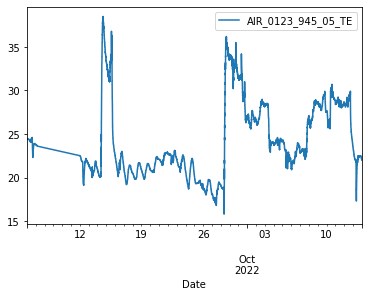

In [5]:
DF_list[1].plot()

<AxesSubplot:xlabel='Date'>

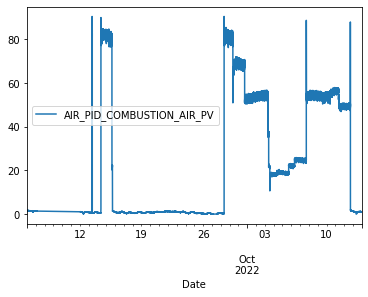

In [6]:
DF_list[2].plot()

<AxesSubplot:xlabel='Date'>

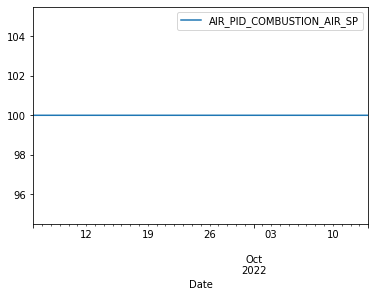

In [7]:
DF_list[3].plot()

<AxesSubplot:xlabel='Date'>

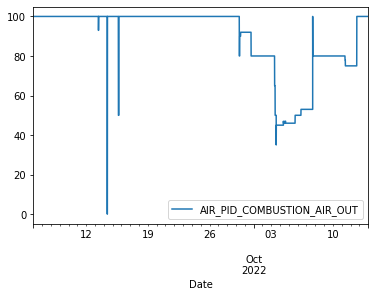

In [8]:
DF_list[4].plot()

## Merge the dataframes of sensor data together

In [9]:
start = time.time()
import functools as ft
df_merged = DF_list[1].copy()

for i in range(2, len(DF_list)):
    df_merged = df_merged.merge(DF_list[i],on=['Date'],how='left')
end = time.time()
print(end - start)

df_merged

2.1318564414978027


,AIR_0123_945_05_TE,AIR_PID_COMBUSTION_AIR_PV,AIR_PID_COMBUSTION_AIR_SP,AIR_PID_COMBUSTION_AIR_OUT,AIR_DRIVE_AIR_SPEED,AIR_0123_945_03_PT,FURNACE_PID_FURNACE_PRESSURE_SP,FURNACE_PID_FURNACE_PRESSURE_OUT,FURNACE_0126_341_04_O2,FURNACE_0126_341_02_PDT,...,ROOF_0104_300_01_TC,ROOF_0104_300_02_TC,ROOF_0104_300_03_TC,ROOF_0104_300_04_TC,ROOF_0104_300_05_TC,ROOF_0104_300_06_TC,ROOF_0104_300_07_TC,ROOF_0104_300_08_TC,ROOF_0104_300_09_TC,ROOF_0104_300_10_TC
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-06 00:00:00,24.50,1.551648,100.0,100.0,0.0,1.519097,20.0,100.0,0.0,-1.064453,...,25.000000,25.70001,24.70001,24.700020,0.0,25.000000,26.39999,24.89999,25.89999,25.399990
2022-09-06 00:00:10,24.50,1.627604,100.0,100.0,0.0,1.627604,20.0,100.0,0.0,-1.080006,...,25.080020,25.80002,24.60001,24.500000,0.0,25.000000,26.39999,24.89999,25.80002,25.399990
2022-09-06 00:00:20,24.50,1.555266,100.0,100.0,0.0,1.562500,20.0,100.0,0.0,-1.078378,...,25.000000,25.80002,24.60001,24.500000,0.0,25.000000,26.50000,25.00000,25.89999,25.489990
2022-09-06 00:00:30,24.50,1.576967,100.0,100.0,0.0,1.584202,20.0,100.0,0.0,-1.076027,...,25.000000,25.70001,24.60001,24.500000,0.0,25.000000,26.50000,25.00000,25.80002,25.399990
2022-09-06 00:00:40,24.50,1.627604,100.0,100.0,0.0,1.627604,20.0,100.0,0.0,-1.090857,...,25.000000,25.70001,24.60001,24.500000,0.0,25.050005,26.50000,25.00000,25.80002,25.449995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-13 23:59:20,22.03,0.940393,100.0,100.0,0.0,0.940393,20.0,96.0,21.0,-8.362631,...,72.899990,196.20000,323.30000,434.300000,0.0,501.300000,26.50000,0.00000,23.30002,452.100000
2022-10-13 23:59:30,22.05,0.998264,100.0,100.0,0.0,0.940393,20.0,96.0,21.0,-8.360460,...,73.000000,196.20000,323.40000,434.400000,0.0,501.300000,26.50000,0.00000,23.20001,452.000000
2022-10-13 23:59:40,22.01,1.012731,100.0,100.0,0.0,1.012731,20.0,96.0,21.0,-8.362268,...,73.100010,196.30000,323.40000,434.400000,0.0,501.300000,26.30002,0.00000,23.20001,451.900000


## Save the merged dataframe

In [10]:
df_merged.to_pickle('merged_sensor_df.pkl')